# Outline

The package **soundscape_IR** is an open-source Python toolbox that utilizes non-negative matrix factorization (NMF) in audio source separation. This is a quick start guide for the application of **soundscape_IR** in acoustic analysis. For more information, please visit our [Github](https://github.com/meil-brcas-org/soundscape_IR).</br></br>

<center><img src="https://raw.githubusercontent.com/yijensun/soundscape_IR/master/docs/images/workflow_v14.png" width="1000"/></center>

This guide contains four sections:
1. Audio visualization
2. Model training
3. Deployment and spectrogram reconstruction
4. Presence detection

# Installation

To install soundscape_IR, clone the repository and install the required packages 

In [ ]:
# Clone soundscape_IR from GitHub @schonkopf
!git clone https://github.com/meil-brcas-org/soundscape_IR.git

# Install required packages
%cd soundscape_IR
%pip install -r requirements.txt

Cloning into 'soundscape_IR'...
remote: Enumerating objects: 1916, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 1916 (delta 8), reused 0 (delta 0), pack-reused 1900
Receiving objects: 100% (1916/1916), 56.60 MiB | 22.74 MiB/s, done.
Resolving deltas: 100% (1268/1268), done.
/content/soundscape_IR
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.7 MB 13.9 MB/s 
     |████████████████████████████████| 994 kB 67.8 MB/s 
     |████████████████████████████████| 183 kB 70.0 MB/s 
     |████████████████████████████████| 6.8 MB 50.7 MB/s 
     |████████████████████████████████| 16.7 MB 43.5 MB/s 
     |████████████████████████████████| 6.3 MB 49.5 MB/s 
  Created wheel for librosa: filename=librosa-0.8.0-py3-none-any.whl size=201396 sha256=3ff81a27f9395c9b3c0204de53ac406a520d1195f873d9705acb3fe5773061bc
  Stored in directory: /root/.

# 1. Audio visualization

**soundscape_IR** provides a function ```audio_visualization``` to transform an audio into a spectrogram on the hertz or mel scale. It also enables the use of Welch’s averaging method and spectrogram prewhitening in noise reduction. This example uses a short audio clip of sika deer calls and insect calls to demonstrate the ecoacoustic application of source separation.

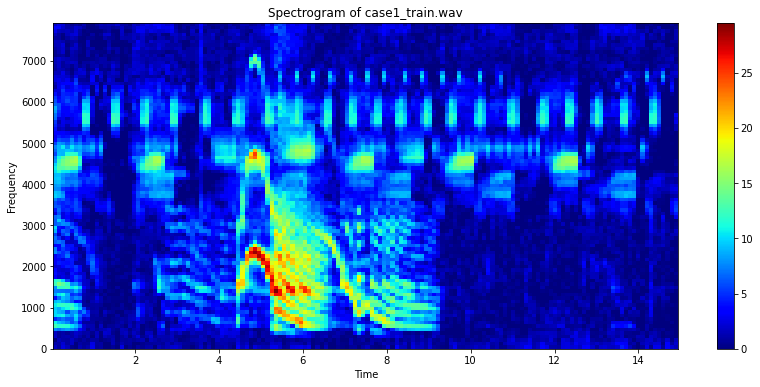

In [ ]:
from soundscape_IR.soundscape_viewer import audio_visualization

# Define spectrogram parameters
sound_train = audio_visualization(filename='case1_train.wav', path='./data/wav/', offset_read=0, duration_read=15,
                                  FFT_size=512, time_resolution=0.1, prewhiten_percent=10, f_range=[0,8000])

# 2. Model training

After preparing the training spectrgram, we can train a model with ```source_separation```. NMF learns a set of basis functions to reconstruct the training spectrogram. In **soundscape_IR**, we can apply PC-NMF to separate the basis functions into two groups according to their source-specific periodicity. In this example, one group of basis funcitons is associated with deer call (mainly < 4 kHz) and another group is associated with noise (mainly > 3.5 kHz). Save the model for further applications.

Running periodicity-coded NMF
Feature learning...


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/content/soundscape_IR/soundscape_viewer/source_separation.py:142: RuntimeWarning: invalid value encountered in true_divide
  mask=np.divide(source,source0)


Periodicity learning...
Done
Successifully save to ./data/model/deer_model.mat


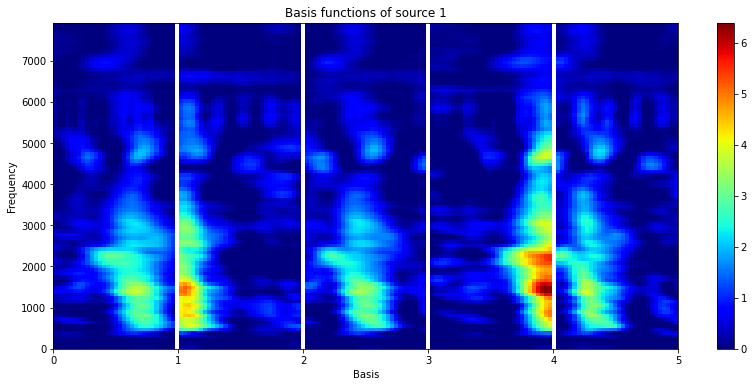

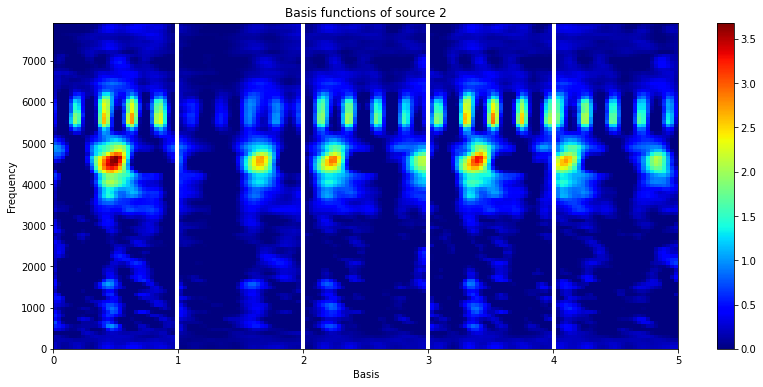

In [ ]:
from soundscape_IR.soundscape_viewer import source_separation

# Define model parameters
model=source_separation(feature_length=30, basis_num=10)

# Feature learning
model.learn_feature(input_data=sound_train.data, f=sound_train.f, method='PCNMF')

# Plot the basis functions of two sound source
model.plot_nmf(plot_type='W', source=1)
model.plot_nmf(plot_type='W', source=2)

# Save the model
model.save_model(filename='./data/model/deer_model.mat')

# 3. Deployment and spectrogram reconstruction

Generate another spectrogram for testing the source separation model.

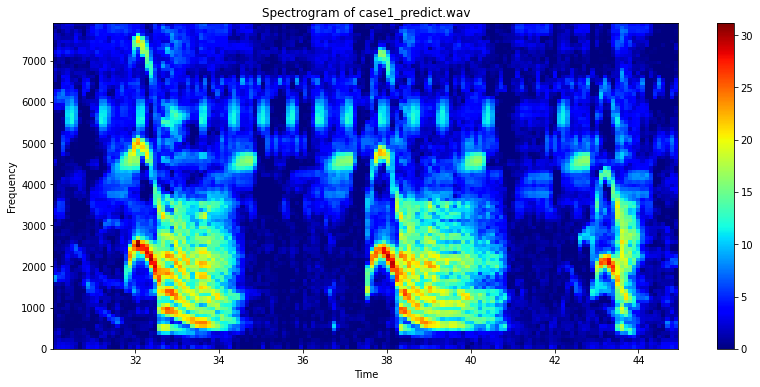

In [ ]:
# Prepare a spectrogram
sound_predict=audio_visualization(filename='case1_predict.wav', path='./data/wav/', offset_read=30, duration_read=15,
                                    FFT_size=512, time_resolution=0.1, prewhiten_percent=10, f_range=[0,8000])

Load the saved model and perform source separation. After the prediction procedure, plot the reconstructed spectrograms to evaluate the separation of deer calls and noise.

Model parameters check
Minima and maxima frequancy bin: 0.0 Hz and 7924.21875 Hz
Frequancy resolution: 86.1328125 Hz
Feature length: 30
Number of basis: 10
Number of source: 2


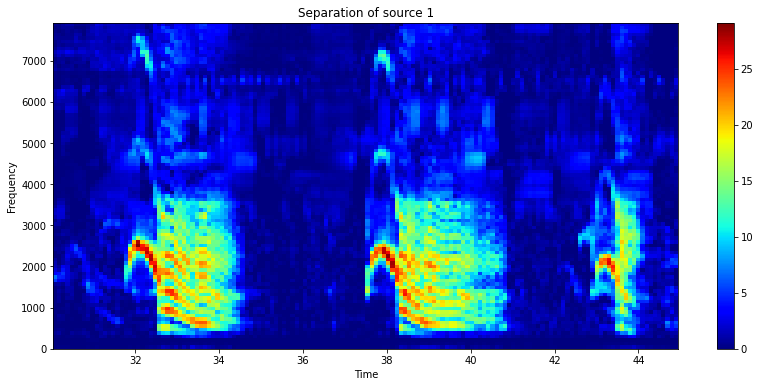

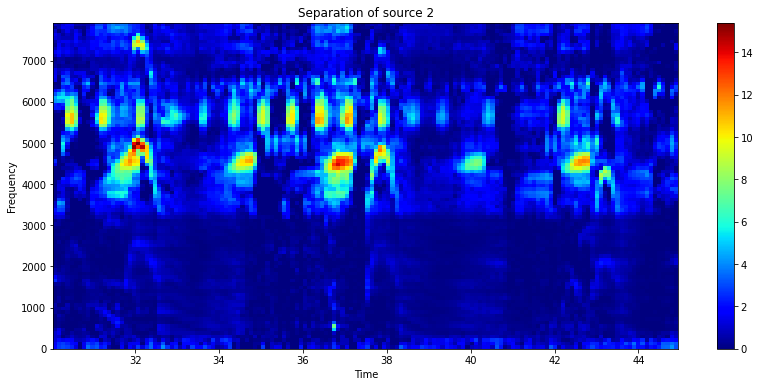

In [ ]:
# Deploy the model
model=source_separation()
model.load_model(filename='./data/model/deer_model.mat')
model.prediction(input_data=sound_predict.data, f=sound_predict.f)

# View individual reconstructed spectrogram
model.plot_nmf(plot_type = 'separation', source = 1)
model.plot_nmf(plot_type = 'separation', source = 2)

# 4. Presence detection

With the reconstructed spectrogram, we can use the function ```spectrogram_detection``` to detect the presence of target signals (e.g., deer calls). This function will generate a txt file contains the beginning time, ending time, minimum frequency, and maximum frequency of each detected call. Explore the detection result in [Raven software](https://ravensoundsoftware.com/).

Successifully save to ./data/txt/deer_detection.txt


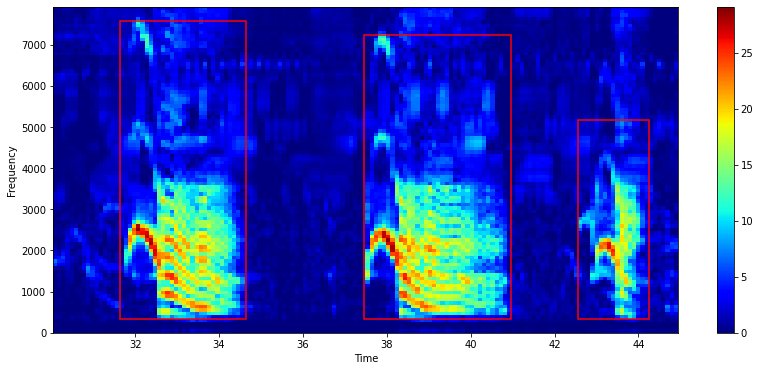

In [ ]:
from soundscape_IR.soundscape_viewer import spectrogram_detection

# Choose the source for signal detection
source_num = 1
    
# Define the detection parameters
sp=spectrogram_detection(model.separation[source_num-1], model.f, threshold=5.5, smooth=1, minimum_interval=0.5, 
                           filename='deer_detection.txt', path='./data/txt/')